## import dependencies:

In [ ]:
# detect and init the tpu
tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
# istantiating a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strateg=tf.distribute.TPUStrategy(tpu)
       

In [2]:


import sys
if not sys.warnoptions:
    import warnings
    warnings.filterwarnings('ignore')
    
from __future__ import annotations
    
from tqdm import trange
from time import time

from typing import Union
from typing import Optional
from typing import List
from typing import Tuple
from typing import Callable

from os.path import join
from os import listdir

from itertools import chain

from numpy import array
from numpy import ndarray
import numpy as np

from pandas import DataFrame
from pandas import read_csv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import Tensor
from tensorflow import constant
from tensorflow import cast
from tensorflow import float32
from tensorflow import shape
from tensorflow.debugging import assert_equal 
from tensorflow import convert_to_tensor
from tensorflow import keras
from tensorflow.data import Dataset

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import ReLU
from keras.activations import relu
from keras.layers import Layer
from keras.models import Model
from keras import Sequential
from keras.backend import flatten
from keras.backend import sum
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping 
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.losses import Loss
from keras.metrics import Metric
from keras.utils import normalize


#from kerastuner.tuners import RandomSearch
#from kerastuner.tuners import Hyperband
#from kerastuner.tuners import BayesianOptimization

import tensorboard

# TENSORFLOW AS BACKEND OF KERAS
tf.keras.backend.backend()

'tensorflow'

## Configurations:

check out this https://www.kaggle.com/docs/tpu#tpu1 for making use of TPU accelator with keras, tensorflow...etc

In [3]:
def configurations(accelerator:Optional[Union['GPU', 'TPU']]='GPU',
                   tf_seed:int=1234,
                   np_seed:int=42)->str:
    
    # we want to generate the same random tensors or arrays each time we raun the code(get the same outputs rhen same results)
    # this come handy in data augmentation(image and label must have the same transformations)
    tf.random.set_seed=tf_seed 
    np.random.seed=np_seed
    
    if tf.config.list_physical_devices('TPU') != []:
        print('to enable "TPU" you must write down some more code')
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        # instantiate a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
        
        # you need to add 'with tpu_strategy.scope():' before define your model
        accelerator='TPU VM v3-8'
        return accelerator
        
    elif tf.config.list_physical_devices('GPU') != []:
         print( 'the aviable "GPU" are ["GPU P100", "GPU T4x2"]')
         print('you are enable "GPU", you do not need to write any more code ')
         accelerator='GPU'
         return accelerator
    
    else :
        raise RuntimeError('you must to enable "GPU" or "TPU"',
                           'On the right-hand side' ,
                           'click on the dropdown menu next to Accelerator',
                        'select "GPU" or "TPU" from the list ["GPU P100", "GPU T4 x2" "TPU VM v3-8"]')
        

configurations()    

to enable "TPU" you must write down some more code
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-01-30 05:37:23.013659: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.013758: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.013842: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.013913: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.014000: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.014226: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:37:23.014310: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

'TPU VM v3-8'

if you are using 'TPU VM v3-8' as you choice accelerator  you need to add one more few lines of code before define your model as it shown in the below picture.

In [5]:
# Enabling growth memory for GPUs and TPUs
def Set_MemoryGrowth():
    
    gpus=tf.config.list_physical_devices('GPU')
    
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print('memory growth enable for all GPUs')
        except RuntimeError as e:
               print("Error enabling memory growth for GPUs:", e)
    else: 
               print('you can not enable memory growth for TPUs')
                
Set_MemoryGrowth()

you can not enable memory growth for TPUs


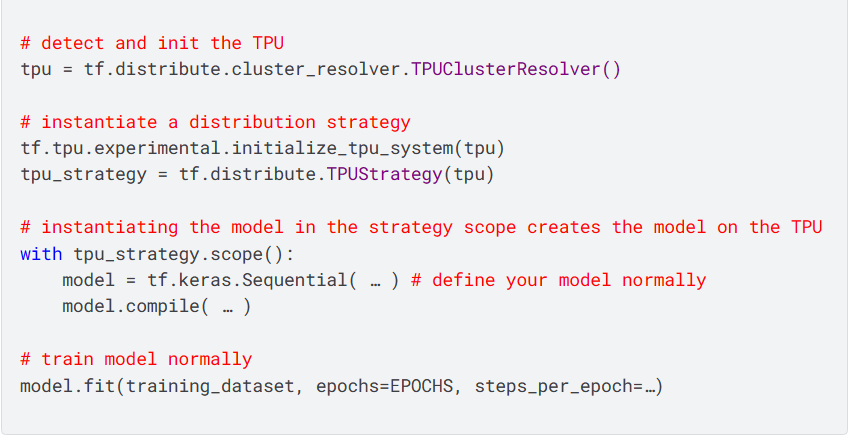

In [16]:
# define a simple decorator(inner function) to mesure the execution of a function
def measure_time(func:Callable)->Callable:
    '''
    args: one argument, is the function that we want to decorated(e,g functions that:
    build the model, train the model, optimize the model, ...etc)
    '''
    # define the wrapper function that executes the original function(e,g arg func)
    def wrapper(*args, **kwargs)->float:
        '''
        the wrapper function have the same argument as the object(e,g arg)function
        '''
        start_time=time()
        # call the object function to process and manipulate ...
        result=func(*args, **kwargs)
        end_time=time()
        
        processing_time=end_time-start_time
        print(f'the processing time is {processing_time:.2f} secondes')
        return result
    
    return wrapper

# applying that decorator in a simple function
@measure_time
def simple_function(n):
  """A simple function that calculates the sum of squares of numbers from 1 to n."""
  S= 0
  for i in trange(1, n + 1):
    S+=i**2
  return S

# Example usage
n = 10000000
result = simple_function(n)

        

100%|██████████| 10000000/10000000 [00:06<00:00, 1640875.35it/s]

the processing time is 6.10 secondes


if you don't love build things from scratch you can  use the %%timeit magic command to measure the execution time of a code cell

In [6]:
%%timeit
def simple_function(n):
  """A simple function that calculates the sum of squares of numbers from 1 to n."""
  S= 0
  for i in trange(1, n + 1):
    S+=i**2
  return S


# Example usage
n = 10000000
simple_function(n)

100%|██████████| 10000000/10000000 [00:05<00:00, 1693346.79it/s]

5.91 s ± 83.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# the submission file
submission_path='/kaggle/input/blood-vessel-segmentation/sample_submission.csv'
example_submission=read_csv(submission_path)
example_submission

,id,rle
0,kidney_5_0000,1 1 100 10
1,kidney_5_0001,1 1 100 10
2,kidney_6_0000,1 0
3,kidney_6_0001,1 0


In [10]:
# the sample from ttrain_rles csv file
train_rles_path='/kaggle/input/blood-vessel-segmentation/train_rles.csv'
sample_train_rles=read_csv(train_rles_path)
sample_train_rles.head()


,id,rle
0,kidney_1_dense_0000,1 0
1,kidney_1_dense_0001,1 0
2,kidney_1_dense_0002,1 0
3,kidney_1_dense_0003,1 0
4,kidney_1_dense_0004,1 0


## Surface Dice Metric for evaluation:

the mathematic formula of the $surface$ $~$ $dice$ as a metric for segmentation is giveen by:

Surface_Dice = $2 * |A ∩ B| / (|A| + |B|)$ $(\star)$

where:

$A$ represent $labels$ .

$B$ represent the predictions.

we add some real positive called $tolerance$ (to prevent divded by zero), the defaut value is set to 0.0.

we rewrite the $(\star)$ , we obtain:

Surface_Dice_with_tolerance = $2 * (|A ∩ B|+tolerance)/ (|A| + |B|+tolerance)$





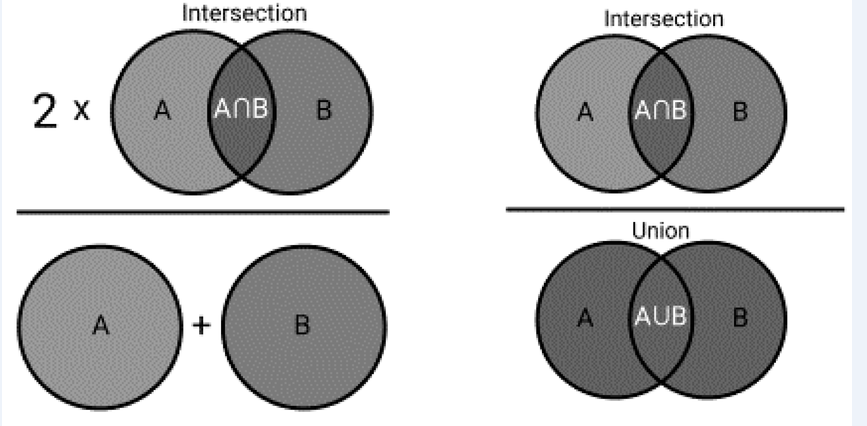

In [11]:

class Dice(y_true:Union[Tensor, array, DataFrame],
                 y_pred:Union[Tensor, array, DataFrame],
                 tolerance:Optional[Union[float, int]]=0.0)->float:
    
          '''
          :param y_true:labels
          :param y_pred:predictions
          :param tolerance:float
          '''
          dtype=Union[ type(Tensor), type(ndarray), type(DataFrame)]
            
          if isinstance(tolerance, Union[float, int]):
             assert tolerance>=0.0
          else:
              raise TypeError(f'the dtype {type(tolerance)} does not supported')

         
          if isinstance(y_true, dtype):
              y_pred=convert_to_tensor(y_pred)
            
          else:
                raise TypeError(f"{type(y_true)} is Unsupported type."
                                     f"Expected TensorFlow tensor or NumPy array or pandas DataFrame")


          if isinstance(y_pred, dtype):
              y_pred=convert_to_tensor(y_pred)
        
          else:
                raise TypeError(f"{type(y_pred)} is Unsupported type."
                                     f"Expected TensorFlow tensor or NumPy array or pandas DataFrame")

          assert shape(y_true)==shape(y_pred)

          # flatten the labels and predictions
          y_true=flatten(y_true)
          y_pred=flatten(y_pred)

          intersection=sum(y_pred*y_true, axis=0)
          union=sum(y_true, axis=0)+sum(y_pred, axis=0)

          if union+tolerance==0:
              raise ZeroDivisionError(f'we can not divide by zero, '
                                      f'change the value{tolerance} of tolerance ')

          dice_coefficient=(2.0*intersection+tolerance)/(union+tolerance)

          return dice_coefficient

# Fake numerical data for testing surface dice loss function

# Ground truth values
'''
ground_truth=<Tensor: shape=(5, 5), dtype=uint16, numpy=([
    array[0, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
], dtype=uint16>)

# Predicted values
predicted=<Tensor: shape=(5, 5), dtype=uint16, numpy=([
    array[0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
], dtype=uint16>)
type(predicted)
'''

SyntaxError: invalid syntax (2076513897.py, line 1)

In [8]:
class DiceLoss(Loss):
    
    def __init__(self,
                 smooth=1)->None:
    
              # Define the inializer of the parent class
              super(Dice, self).__init__(**kwargs)
              self.smooth=smooth
        
    def call(self, y_true, y_pred):
        
        # flatten the true labels and predicted labels
        self.y_true=K.flatten(y_true)
        self.y_pred=K.flatten(y_pred)
        
        # computing the score
        self.score=(K.sum(y_true*y_pred)+self.smooth)/(K.sum(y_true)+K.sum(y_pred)+self.smooth)
        
        return 1-self.score    
        
    

In [9]:
class DiceMetric(Metric):
    
      def __init__(self, 
                  with_iou_metric=False,
                  with_coef_metric=True,
                  smooth:float=1.)->None:
            
            super(DiceMetric, self).__init__()
            assert with_iou_metric is not  with_coef_metric # to make use of one metric not 2 or no one
            self.iou_metric=with_iou_metric
            self.coef_metric=with_coef_metric
            self.smooth=smooth
            
      def call(self, y_true, y_pred)->float:
          
            # First we flatten the labels
            y_true=K.flatten(y_true)
            y_pred=K.flatten(y_pred)
            
            if self.coef_metric:
                    # computing the intesection
                    intersection=K.sum(y_true*y_pred)
                    return (2.+intersection+self.smooth)/(K.sum(y_true)+K.sum(y_pred)+self.smooth)
            
            else:
                    # computing  the intersection of the the value absolue over axes 1, 2, 3
                    intersection=K.sum(K.abs(y_true*y_pred), [1, 2, 3])
                    
                    # computing  the union of the the value absolue over axes 1, 2, 3
                    union=K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection  # A U B = A + B -intersection(A, B)
                    
                    # computing the mean of the intersection versus union over axis=0
                    iou=K.mean((intersection+self.smooth)/(union+self.smooth), axis=0)
                    
                    return iou
                    
                
            

## Data Preparation and Preprocessing:

In [11]:
import os
# setting the paths of the train data
train_datasets=['/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense',
             '/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi', 
             '/kaggle/input/blood-vessel-segmentation/train/kidney_2',
             '/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense',
             '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse']

# setting the path of test data
test_datasets=['/kaggle/input/blood-vessel-segmentation/test/kidney_5', 
          '/kaggle/input/blood-vessel-segmentation/test/kidney_6']


def sorting_images(dataset):
    
      # the train_path 4 doesn't contains images so we must skip it
      if dataset is not train_datasets[3]:
            images_path = os.path.join(dataset, 'images')
            image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')], 
                                reverse=False)
            return image_files
            
def sorting_labels(dataset):
    
    labels_path = os.path.join(dataset, 'labels')
    labels_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')], 
                                reverse=False)
    return labels_files
        
trai_images=[]
trai_labels=[]
tes_images=[]
train_images_paths=map(sorting_images, train_datasets)  
train_labels_paths=map(sorting_labels, train_datasets) 
test_images_paths=map(sorting_images, test_datasets)


for train_pa in train_images_paths:
   trai_images.append(train_pa)

for train_la in train_labels_paths:
   trai_labels.append(train_la)

for test_pa in test_images_paths:
   tes_images.append(test_pa)


# the trai_images contains None path , we must clean it 
for paths in trai_images:
    if paths is None:
       trai_images.remove(paths)
    else:
       for path in paths:
          if path is None:
            paths.remove(path)
            
# as we said before the fourth dataset (indice 3 due we start from 0) d
# doesn't contains images so we must remove their labels

labels3=trai_labels[3]
trai_labels.remove(labels3)

# check out that we have the same number of images and labels
for i in range(4):
    assert len(trai_images[i])==len(trai_labels[i])
    print('images', len(trai_images[i]), 'labels', len(trai_labels[i]))

# list of lists to a list

def list_of_lists_to_list(list_of_lists:List[list])->list:
    #assert  list_of_lists is list
    flat_list=list(chain.from_iterable(list_of_lists))
    return flat_list

# train_images_paths=list_of_lists_to_list(trai_images)  ==> the train images are not the same shapes , 
                                                          #so do not flatten the lists of tarin  images
# train_labels_paths=list_of_lists_to_list(trai_labels)  ==> the train labels are not the same shapes 
test_images_paths=list_of_lists_to_list(tes_images)

print('#######------path of the test images######-----')
test_images_paths


images 2279 labels 2279
images 1397 labels 1397
images 2217 labels 2217
images 1035 labels 1035
#######------path of the test images######-----


['/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0000.tif',
 '/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif',
 '/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0002.tif',
 '/kaggle/input/blood-vessel-segmentation/test/kidney_6/images/0000.tif',
 '/kaggle/input/blood-vessel-segmentation/test/kidney_6/images/0001.tif',
 '/kaggle/input/blood-vessel-segmentation/test/kidney_6/images/0002.tif']

In [12]:
# images_paths, label_paths to tensors
start_time=time()
def path_to_tensor(path):
    img=Image.open(path)
    tensor=convert_to_tensor(img)
    return tensor

X_train=[]
y_train=[]
X_test=[]

for i in trange(4):
    X=map(path_to_tensor, trai_images[i])
    X_train.append(X)
    y=map(path_to_tensor, trai_labels[i])
    y_train.append(y)

X_test_map=map(path_to_tensor,  test_images_paths )

# convert a map object into a list
for i in trange(4):
  X_train[i]=list(X_train[i])
  y_train[i]=list(y_train[i])
X_test=list(X_test_map)

# convert a list into tensor of 3D
for i in trange(4):
    X_train[i]=convert_to_tensor(X_train[i])
    y_train[i]=convert_to_tensor(y_train[i])
X_test=convert_to_tensor(X_test)


end_time=time()
t=end_time-start_time
print(f'the temps for executionis: {t:.4f}secondes ')

100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

the temps for executionis: 561.3540secondes 


In [13]:
for i in range(4):
    print(f'elements of X_images{i} has the shape {X_train[i][0].shape}  <====>   elements of labels{i} has the shape {y_train[i][0].shape}')
X_train[0]

elements of X_images0 has the shape (1303, 912)  <====>   elements of labels0 has the shape (1303, 912)
elements of X_images1 has the shape (1928, 1928)  <====>   elements of labels1 has the shape (1928, 1928)
elements of X_images2 has the shape (1041, 1511)  <====>   elements of labels2 has the shape (1041, 1511)
elements of X_images3 has the shape (1706, 1510)  <====>   elements of labels3 has the shape (1706, 1510)


<tf.Tensor: shape=(2279, 1303, 912), dtype=uint16, numpy=
array([[[22229, 21842, 22422, ..., 20789, 20733, 20711],
        [22458, 22184, 22584, ..., 21060, 20893, 20920],
        [22308, 22078, 22214, ..., 21242, 20942, 20640],
        ...,
        [21848, 21609, 22175, ..., 21029, 20890, 21145],
        [21573, 21569, 22062, ..., 20899, 20983, 20793],
        [21617, 21943, 22238, ..., 21113, 20947, 20557]],

       [[22178, 22019, 22237, ..., 20884, 20730, 20544],
        [22273, 22151, 22430, ..., 21118, 20976, 20777],
        [22651, 22293, 22106, ..., 20937, 20873, 21126],
        ...,
        [20953, 21456, 21894, ..., 20873, 20870, 21033],
        [21474, 21166, 21405, ..., 21325, 20791, 20638],
        [21923, 21520, 21771, ..., 20980, 20660, 20448]],

       [[22426, 22289, 22583, ..., 21007, 20984, 20835],
        [22271, 22245, 22327, ..., 21268, 20898, 20921],
        [22136, 22337, 22163, ..., 21119, 20552, 20810],
        ...,
        [21218, 21657, 21583, ..., 20907, 20

so we can not $ concatenate$ the train data in one large data

In [14]:
X_train[0].shape
#X_train[0]=X_train[0][0:X_train[0].shape[0]//10]
#y_train[0]=y_train[0][0:y_train[0].shape[0]//10]
X_train[0].shape, y_train[0].shape

(TensorShape([2279, 1303, 912]), TensorShape([2279, 1303, 912]))

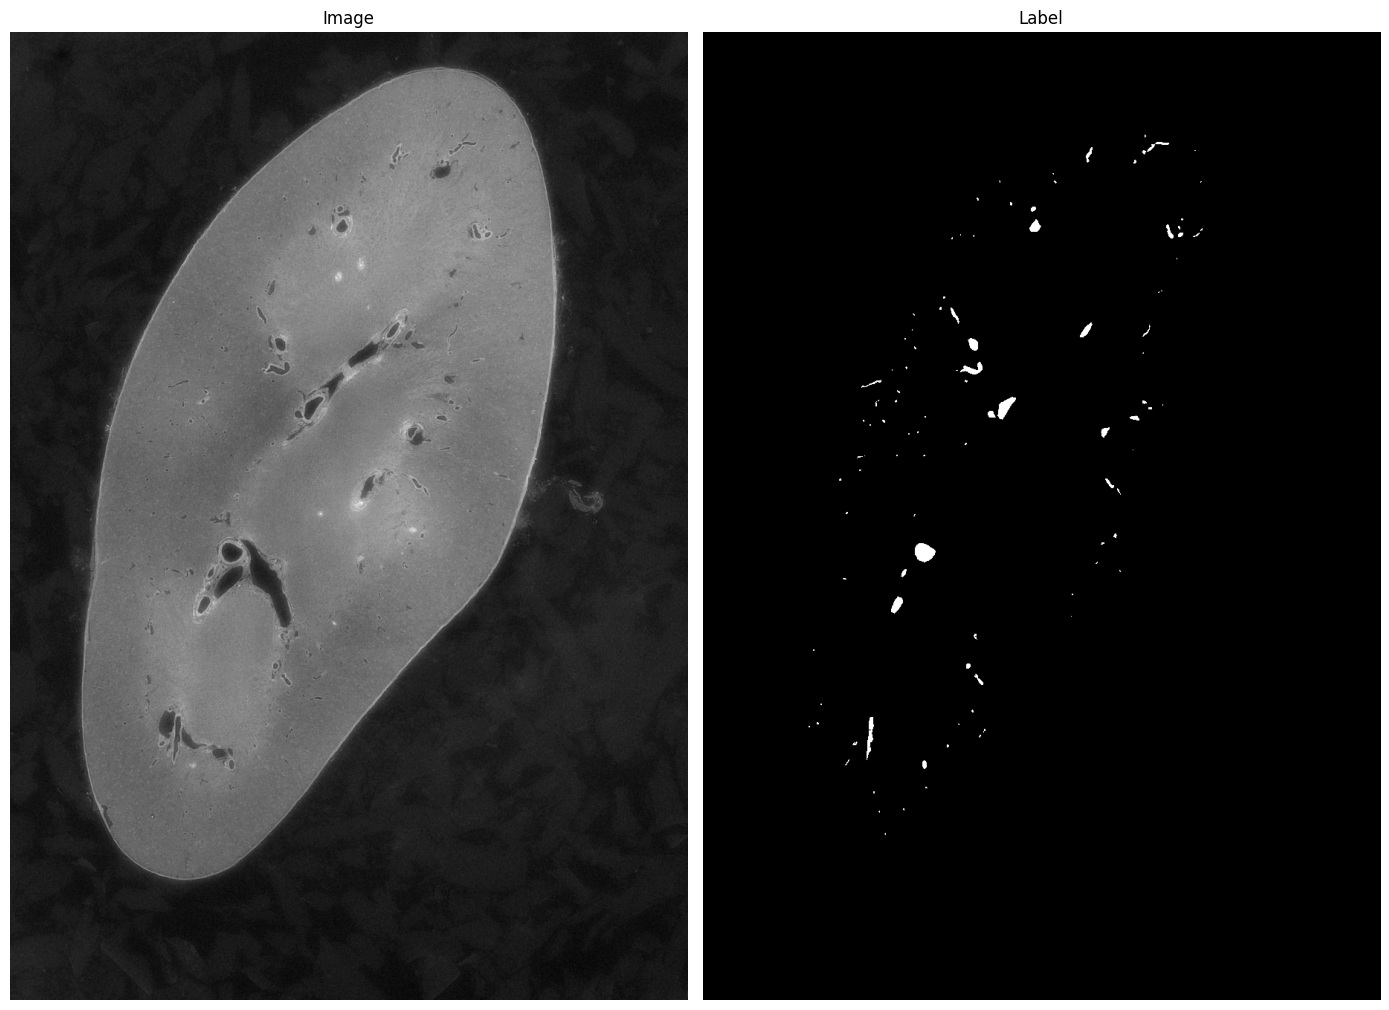

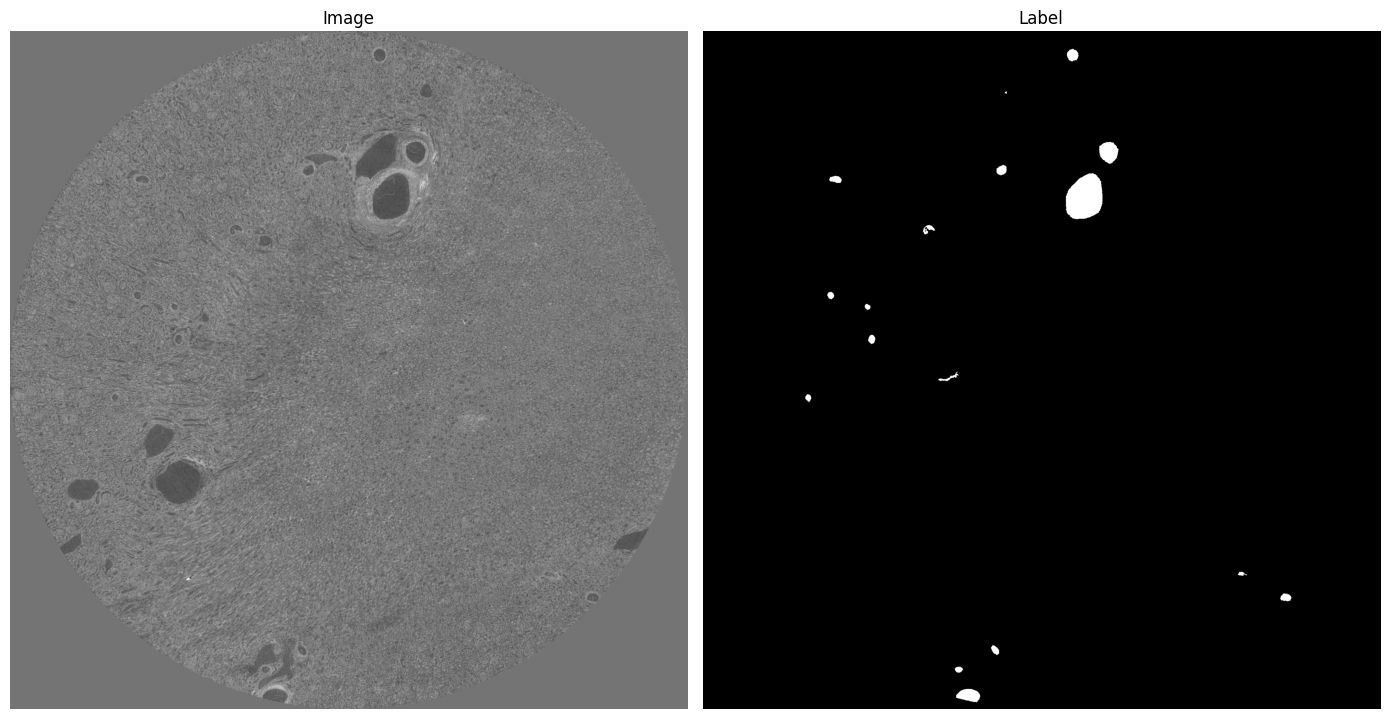

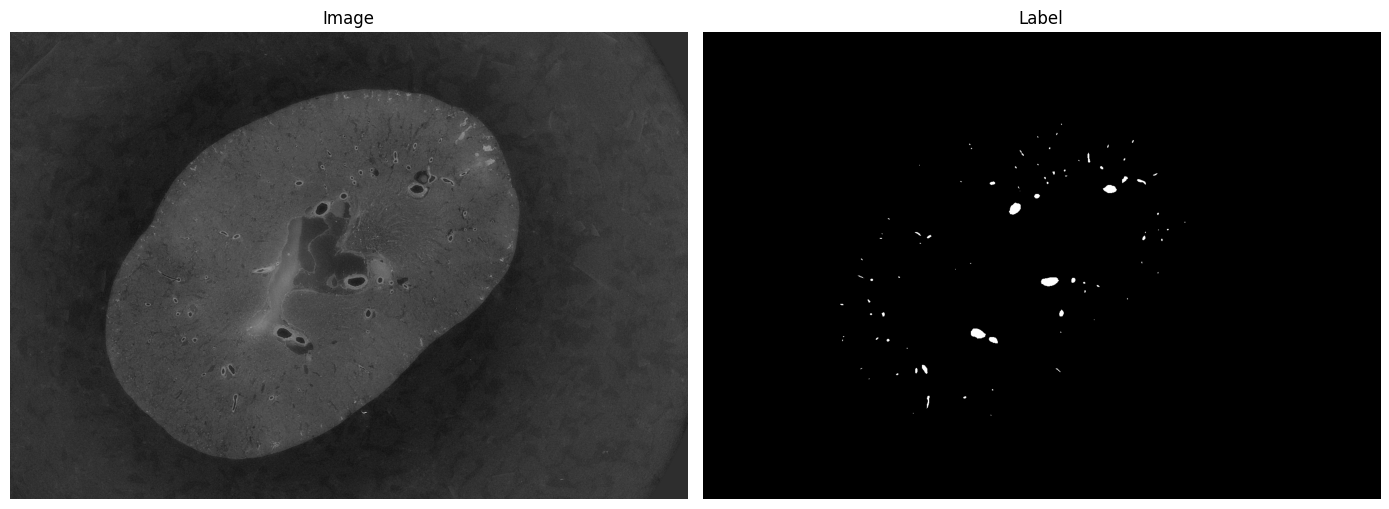

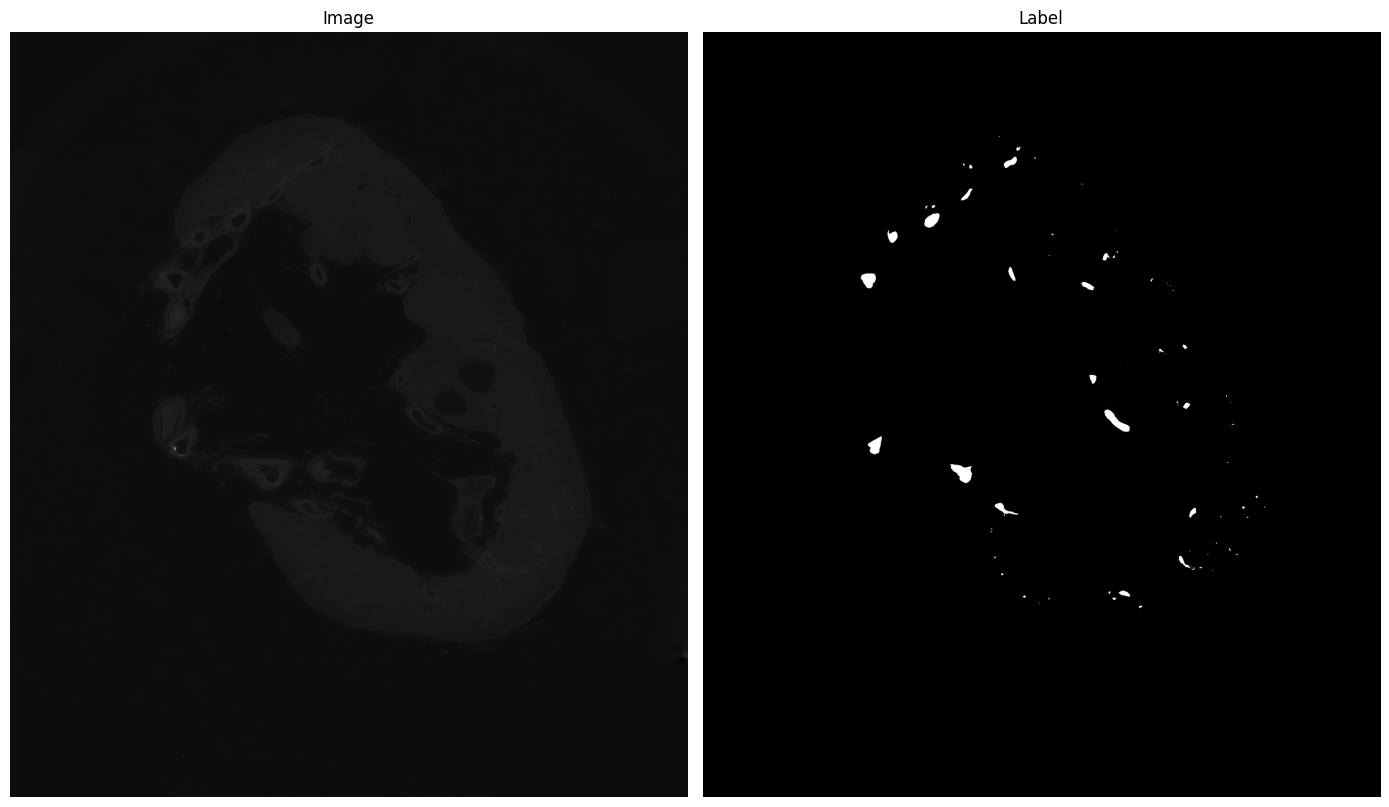

the processing time is 2.39 secondes


In [17]:
@measure_time
def disply_samples( index:int=450,figsize:tuple[int]=(14, 20))->None:
    
    for num_dataset in range(4):
        assert index in range(len(X_train[num_dataset]))
        # extracting the images and labels 
        image=X_train[num_dataset][index]
        label=y_train[num_dataset][index]
    
        # Create subplots for displaying images and segmentations
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        
        axs[0].imshow(image, cmap='gray')
        axs[0].axis('off')
        axs[0].set_title('Image')

        # Display labels
        axs[1].imshow(label, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('Label')

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()
disply_samples()
      

In [18]:
# normalizing data
import numpy as np
@measure_time
def scaling_data(dataset, normalization=True, standardization=False)->Tuple[Tensor, Tensor]:
    
    assert normalization is not standardization
    
    if normalization:
           dataset=np.asarray(dataset)
           dataset=Dataset.from_tensor_slices(dataset)
           normalized_data=dataset.map(lambda x:(x-tf.reduce_min(x, axis=0))/(tf.reduce_max(x, axis=0)-x))
           return normalized_data
    
    else:  
           dataset=np.asarray(dataset, dtype=np.float32)
           dataset=Dataset.from_tensor_slices(dataset)
           mean=tf.reduce_mean(dataset, axis=0)
           std_dev=tf.math.reduce_std(dataset, axis=0)
           normalized_data=dataset.map(lambda x:(x-tf.reduce_mean(x, axis=0))/tf.math.reduce_std(x, axis=0))
           return normalized_data

normalized_X_train0=scaling_data(X_train[0])
normalized_X_train0

the processing time is 6.73 secondes


<_MapDataset element_spec=TensorSpec(shape=(1303, 912), dtype=tf.float32, name=None)>

In [19]:
#display the first 5 elements of the dataset
num_elements=5
dataset_subset=normalized_X_train0.take(num_elements)# take the first five element
for element in dataset_subset:
    print(element)
    
    

tf.Tensor(
[[2.5137615  1.2581211  3.3532512  ... 0.48413345 0.3204473  0.30831197]
 [4.0205994  2.2271016  5.085995   ... 0.6680384  0.3915825  0.41673276]
 [2.9195907  1.8482835  2.1879022  ... 0.8194514  0.4149264  0.2751606 ]
 ...
 [1.3435315  0.8746356  2.0355392  ... 0.64472497 0.39017826 0.5555072 ]
 [0.8893587  0.82152975 1.6663078  ... 0.5536627  0.43506944 0.34881088]
 [0.9498182  1.477842   2.2895086  ... 0.7094658  0.41735253 0.23847488]], shape=(1303, 912), dtype=float32)
tf.Tensor(
[[ 3.281496    1.6546512   2.813187   ...  0.3692253   0.37297484
   0.25158373]
 [ 4.2663436   2.135989    4.470721   ...  0.49341086  0.50018835
   0.34620377]
 [61.142857    2.8959045   2.1627605  ...  0.3955089   0.44416243
   0.51811194]
 ...
 [ 0.25504905  0.604357    1.4785714  ...  0.3638938   0.44259328
   0.46815288]
 [ 0.7945545   0.33274958  0.6535058  ...  0.6236831   0.40246478
   0.28810927]
 [ 1.8505898   0.6799117   1.2021759  ...  0.41758645  0.34062606
   0.21635884]], shape=

In [20]:
# we check the shapes the images and labels
print('##########---- Train Data shape -----######')
for i in trange(4):
   for image , label in zip(scaling_data(X_train[i]).take(1), scaling_data(y_train[i]).take(1)):
       print(f'shape of images in dataset {i+1} est {image.shape}<====>shape of labels in dataset {i+1} est {label.shape}')
             
print('##########---- Test Data shape(no labels) -----##########')
for image in scaling_data(X_test).take(5):# take the whole data
    print(f'shape of images  {i} est {image.shape}')
             
    

##########---- Train Data shape -----######


  0%|          | 0/4 [00:00<?, ?it/s]

the processing time is 6.71 secondes
the processing time is 2.99 secondes
shape of images in dataset 1 est (1303, 912)<====>shape of labels in dataset 1 est (1303, 912)


 25%|██▌       | 1/4 [00:17<00:52, 17.48s/it]

the processing time is 12.80 secondes
the processing time is 5.73 secondes
shape of images in dataset 2 est (1928, 1928)<====>shape of labels in dataset 2 est (1928, 1928)


 50%|█████     | 2/4 [00:54<00:57, 28.72s/it]

the processing time is 8.61 secondes
the processing time is 3.77 secondes
shape of images in dataset 3 est (1041, 1511)<====>shape of labels in dataset 3 est (1041, 1511)


 75%|███████▌  | 3/4 [01:16<00:25, 25.85s/it]

the processing time is 6.65 secondes
the processing time is 2.89 secondes
shape of images in dataset 4 est (1706, 1510)<====>shape of labels in dataset 4 est (1706, 1510)


100%|██████████| 4/4 [01:33<00:00, 23.47s/it]

##########---- Test Data shape(no labels) -----##########
the processing time is 0.02 secondes
shape of images  3 est (1303, 912)
shape of images  3 est (1303, 912)
shape of images  3 est (1303, 912)
shape of images  3 est (1303, 912)
shape of images  3 est (1303, 912)


as we can see in the training set ,every dataset's element has their own size and shape , and the test set that contains only images has the same shape as the shape of the training dataset(e,g(1303, 912)).

In [22]:
# assertion of dimensions for the training inputs data(e,g images shapes)
image1=X_train[0][0]    # take the first image of the first dataset
assert  image1.shape.is_compatible_with(tf.TensorShape([1303, 912]))

image2=X_train[1][0]    #take the first image of the second dataset
assert  image2.shape.is_compatible_with(tf.TensorShape([1928, 1928]))

image3=X_train[2][0]    #take the first image of the third dataset
assert  image3.shape.is_compatible_with(tf.TensorShape([1041, 1511]))

image4=X_train[3][0]    #take the first image of the fourth dataset
assert  image4.shape.is_compatible_with(tf.TensorShape([1706, 1510]))

image_test=X_test[0]    #take the first image of the test dataset
assert  image_test.shape.is_compatible_with(image1.shape)

print('assertion is clearning out')


assertion is clearning out


the images are Black-White so we add 1 channel for grayscale intensity (e,hg expanding dimensions selon first axis)as the model will be feeded by images so the input dismention is :$(1, 1303, 912)$

In [21]:
input_dims1=tf.expand_dims(image1, axis=0).shape
input_dims1

NameError: name 'image1' is not defined

## Data Augmentation:

$data$ $~$ $augumentation$ is the technique that commonly used to increase the size of data.

for segmentation tasks, we can applied $augumentation$ through :

$1$-Flipping and Rotating images.(images means images and their labels).

$2$-Cropping images.

$3$-Resizing and Scaling images (as we did )

$4$-Shiffting images and labels.

$5$-add nnoise(random noise, normal noise...)

and more....

you can implement this taking advantage of $tf.image$ , check out this https://www.tensorflow.org/api_docs/python/tf/image for more details, 

or you can take advantage of  $ImageDataGenerator$ from $keras.preprocessing.image$ (but has less features than  $tf.image$) check out this https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image.

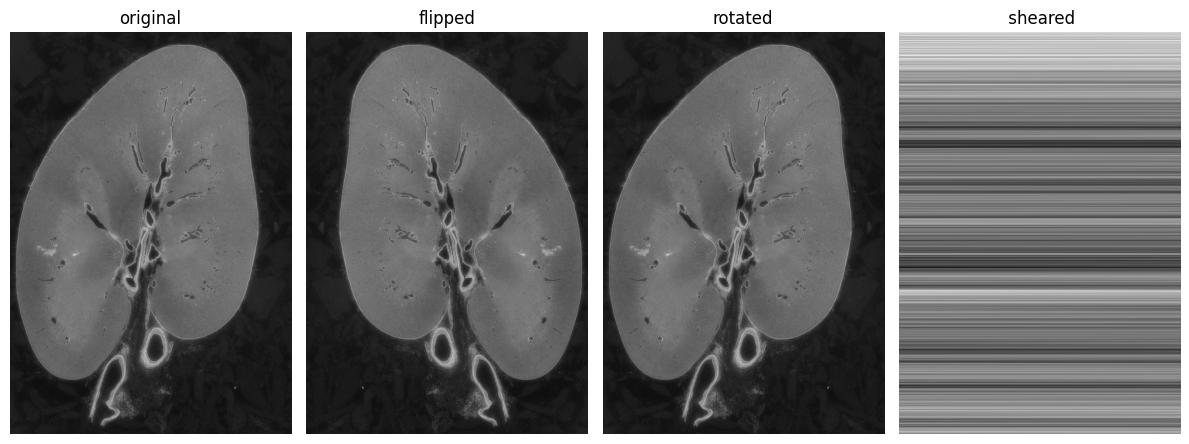

the processing time is 0.74 secondes


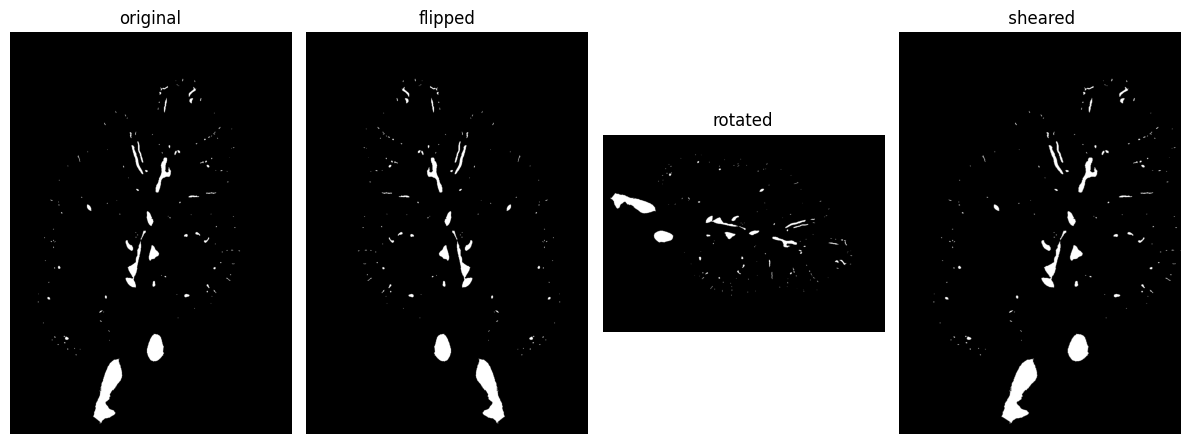

the processing time is 0.62 secondes


In [23]:
import tensorflow as tf
import numpy as np

@measure_time
def display_tranformed_images(data, num_dataset:int=0, index:int=980, figsize=(12, 12))->None:
    
                  assert num_dataset  in range(4)
                  assert index in range(len(data[num_dataset]))
                  
                  # getting an sole image
                  original=data[num_dataset][index]
    
                  # Create subplots for displaying image or label and their transformations
                  fig, axs = plt.subplots(1, 4, figsize=figsize)
                 
                  # Display image
                  axs[0].imshow(original, cmap='gray')
                  axs[0].axis('off')
                  axs[0].set_title('original')

                  # Display flipped_image or flipped_label
                  # Flipping and Add channel dimension for grayscaleimages[i])
                  flipped=tf.image.flip_left_right(np.expand_dims(original, axis=-1))
                  axs[1].imshow(flipped, cmap='gray')
                  axs[1].axis('off')
                  axs[1].set_title('flipped')
                    
                  # Display  rotated_image 
                  # Rotation and Add channel dimension for grayscaleimages[i])
                  angle=tf.random.uniform([], minval=1, maxval=360, dtype=tf.int32)  # Random rotation angle between 1 and 360 degrees
                  rotated=tf.image.rot90(np.expand_dims(original, axis=-1), k=angle // 90)
                  axs[2].imshow(rotated, cmap='gray')
                  axs[2].axis('off')
                  axs[2].set_title('rotated')
                  
                  # Display a sheared image using tf.keras.preprocessing.image.random_shear
                  sheared=tf.keras.preprocessing.image.random_shear(np.expand_dims(original, axis=-1), intensity=90)  # Shear up to 45 degrees
                  # if you want to shear image selon X-axis or y-axis you nedd to importtf tensorflow_addons
                  #sheared_x=tfa.image.shear_x(original, shear=0.2)  # Shear 20% along the x-axis
                  #sheared_y=tfa.image.shear_y(original, shear=-0.15)  # Shear -15% along the y-axis
                  axs[3].imshow(sheared, cmap='gray')
                  axs[3].axis('off')
                  axs[3].set_title(' sheared')



                  # Adjust the layout and display the plot
                  plt.tight_layout()
                  plt.show() 
                    

display_tranformed_images(data=X_train)
display_tranformed_images(data=y_train)

we define a $Augument$ class as subclass of $keras.layers.Layer$ to augument the images using $tf.image$:

In [20]:
class Augment(Layer):
    """
    Data augmentation layer for images.

    Args:
        horizontal_flip (bool): Whether to randomly flip images horizontally.
        vertical_flip (bool): Whether to randomly flip images vertically.
        rotation_range (float): Range for random rotation in degrees.
        zoom_range (tuple): Range for random zooming.
        shear_range (float): Range for random shearing in degrees.
        brightness_range (tuple): Range for random brightness adjustment.
        contrast_range (tuple): Range for random contrast adjustment.
    """

    def __init__(self,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rotation_range=0.0,
                 zoom_range=(1.0, 1.0),
                 shear_range=0.0,
                 brightness_range=(1.0, 1.0),
                 contrast_range=(1.0, 1.0),
                 **kwargs):

        # first we define the inilizer of the parent class (Layer)
        super(Augment, self).__init__(**kwargs)
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rotation_range = rotation_range
        self.zoom_range = zoom_range
        self.shear_range = shear_range
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range

    def call(self, inputs, label, training=None):
        if training is not None and not training:
            return inputs
        
        dtype=Union[tf.Tensor, np.ndarray, pd.DataFrame]
        assert isinstance(inputs, classinfo=dtype)
        assert isinstance(labels, classinfo=dtype)

        image = inputs
        segmentation_mask=label

        # Random horizontal flip
        if self.horizontal_flip:
            image = tf.image.random_flip_left_right(image)
            segmentation_mask= tf.image.random_flip_left_right(segmentation_mask)

        # Random vertical flip
        if self.vertical_flip:
            image = tf.image.random_flip_up_down(image)
            segmentation_mask = tf.image.random_flip_up_down(segmentation_mask)

        # Random rotation
        if self.rotation_range > 0.0:
            angle = tf.random.uniform([], -self.rotation_range, self.rotation_range)
            image = tf.image.rot90(image, k=tf.cast(angle, tf.int32))
            segmentation_mask = tf.image.rot90(segmentation_mask, k=tf.cast(angle, tf.int32))

        # Random zoom
        if self.zoom_range[0] != 1.0 or self.zoom_range[1] != 1.0:
            zoom = tf.random.uniform([], self.zoom_range[0], self.zoom_range[1], dtype=tf.float32)
            image = tf.image.resize(image, tf.cast(tf.shape(image)[:2] * zoom, tf.int32))
            segmentation_mask = tf.image.resize(segmentation_mask, tf.cast(tf.shape(segmentation_mask)[:2] * zoom, tf.int32))

        # Random shear
        if self.shear_range > 0.0:
            shear = tf.random.uniform([], -self.shear_range, self.shear_range)
            image = tf.image.shear_x(image, shear)
            segmentation_mask = tf.image.shear_x(segmentation_mask , shear)

        # Random brightness
        if self.brightness_range[0] != 1.0 or self.brightness_range[1] != 1.0:
            brightness = tf.random.uniform([], self.brightness_range[0], self.brightness_range[1])
            image = tf.image.adjust_brightness(image, brightness)
            segmentation_mask = tf.image.adjust_brightness(segmentation_mask, brightness)

        # Random contrast
        if self.contrast_range[0] != 1.0 or self.contrast_range[1] != 1.0:
            contrast = tf.random.uniform([], self.contrast_range[0], self.contrast_range[1])
            image = tf.image.adjust_contrast(image, contrast)
            segmentation_mask=tf.image.adjust_contrast(segmentation_mask, contrast)

        return image, segmentation_mask

before feeded training data into model we needed to add more crucial pipline steps such :

$batching$ by dividing data into smaller batches for more efficient training.

$caching$ copy the data in order to speed up the training.

$shuffling$ to decrease rate of $overfitting$ ...etc

$repeating$ enables continuous training over multiple epochs.

and more...





In [24]:
# Setting values for pipline of preprocessing data
batch_size=32   # as rule of thumb
EPOCHS=20
tf_buffer_size=tf.data.AUTOTUNE # Don't bother yourself, 
                                # TensorFlow will dynamically determinal the optimal buffer_size in function for your accelerator, memory...etc
buffer_size=1000


def process_pipline(dataset):
    
     # Create a TensorFlow dataset from the input data
     dataset=tf.data.Dataset.from_tensor_slices(data)
    
     # Cache  dataset 
     dataset=dataset.cache()
     
     #scaling data
     # dataset=scaling_data(dataset)( we don't apply it, try it)
        
     # Shuffle dataset
     dataset=dataset.shuffle(batch_size=batch_size)
        
     # enable continuous training through several epochs
     dataset=dataset.repeat()
        
     # augmenting data 
     dataset=dataset.map(augment())
    
     # perfetching data
     dataset=dataset.prefetch(buffer_size=tf_buffer_size)
    
     return dataset
        
    

usually in large model of deep learning we use $callbacks$ as method to performance several method such save best parameters of the model or even best model, stop the training where is no progress through earlystopping then provent overfitting , tracking the progress, visualizing results, er can evn use $callbacks$ for fine-tune of the hyperparameters(e,g $tensorbord$ as callback) , add functionalities that indicates the training behaviors ...etc
we implement our Custom Callbacks (earlystopping, modelcheckpoint, tensorboard) as a subclass of $keras.callbacks.Callback$.

if you don't need more flexibility you can call the predefine onses through $ keras.callbacks.EarlyStopping$ or $ keras.callbacks.ModelCheckPoint$ or$keras.callbacks.tensorboard$ , $keras.callbacks.ReduceLROnPlateau$ for reducing and optimizing the learning rate for good performance...etc

In [21]:
class CustomEarlyStopping(Callback):
    
      def __init__(self, monitor:str='val_loss', patience:int=5):
            # Define the inializer of the parent class
            super(CustomEarlyStopping).__init__()
            
            self.monitor=monitor                    # the objectif
            self.patience=patience                  # if there is no improvement after 5 successive training is stopped
            self.best_weights=None                  # such there is no model defined yet or the training are performed
            self.best_metric=float('inf')             # as start point:this for minimization set it -float(inf) for maximization 
            
       
      def on_epoch_end(self, epoch, logs=None):
         '''
          on end of each epoch we update the weights, metric 
          if the metric on the following epoch is better that the precedent epoch otherwise
          preserve the current parameters. if there no improvement after 5 epochs drop out 
          the training process
          
         '''
         assert self.patience in range(epochs)     # if this condition not affirmed this callback will be a waste of time
                                                 # (don't set it very high or very low)
        
         # getting the current metric
         assert logs is not None
         current_metric=logs.get(self.monitor)
         
         if current_metrick<self.best_metric:
            # getting and updating the parameters of the models(e,g weights)
            self.best_weights=self.model.get_weights()
            # updating the metric
            self.best_metric=current_metric
            
         else:
             # if there is no progress in the current epoch decrease patience by 1
             self.patience-=1
             
             # when the patience is run out(e,g patience=0)
             while self.patience==0:
                    # make model stop his training
                    self.model.stop_training=True
                    # updating the parameters of the models
                    self.model.set_weights(self.best_weights)
                    print('Restoring the weights')
                    
class CustomModelCheckpoint(Callback):
      
      def __init__(self, file_path:str=None, monitor='val_accuracy', save_best_only:bool=True):
                   # define the initializer of the parent calss(e,g Callback)
                   super(CustomModelCheckPoint).__init__()
                   self.file_path=file_path
                   self.monitor=monitor
                   self.save_best_only=save_best_only # set it to False if you to save all models
                   self.best_metric=float('inf')
                    
      def on_epoch_end(self, epoch, logs=None):
                    assert logs is not None
                    current_metric=logs.get(sel.monitor)
                    if (current_metrtic>self.best_metric) or (not save_best_only):
                        self.model.save(self.file_path.format(epoch=epoch+1))
                        self.best_metric=current_metric

class CustomTensorBoard(Callback):
      
      def __init__(self, log_dir):
            super(CustomTensorBoeard).__init__()
            self.log_dir=log_dir
            self.file_writer=tf.summary.create_file_writer(log_dir)
            
      def on_epoch_end(self, epoch, logs=None):
                 with self.file_writer.as_defaults():
                       for name, value in logs.items():
                             tf.summary.scalar(name, value, step=epoch+1)
                             self.file_writer.flush()
            

# Create an instances for our custom callbacks
early_stopping=CustomEarlyStopping(patience=4)
model_checkpoint=CustomModelCheckpoint('best_model.h5')
tensorboard_callback=CustomTensorBoard('logs')

# stacking custom callbacks in a list
custom_callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
      

NameError: name 'CustomModelCheckPoint' is not defined

## Simple Model Unet:


the $Unet$ model is a popular architecture of convolutional neural network (CNN) that has a gret impact in the field segmentation tasks(especialy in segmentation medical images), it was firstly introdued in the paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation" by Olaf Ronneberger, Philipp Fischer, and Thomas Brox , chaek out this link https://arxiv.org/abs/1505.04597.
$Unet$ has two major composant :
$ Encoder $ and $Decoder$

$Encoder$: the inputs goes through a series of convulation layer(2D) with the kernel size $(3, 3)$ and 'relu' as function activation.

$Decoder$: it takes the outputs of $Encoder$ as inputs that goes in turn by multiples series UpSampling layers (2D), and  the we use Concatenate layer to link The upsampled feature maps with feature maps from the contracting path (skip connections) following by series of convolutinal layer with 'relu' as activation function.

there is lot modifications and enhancement  of $Unet$ archicture,such as $SegNet$, $U-Net++$, $Attention U-Ne$, $R2U-Net$, $TernausNet$...etc



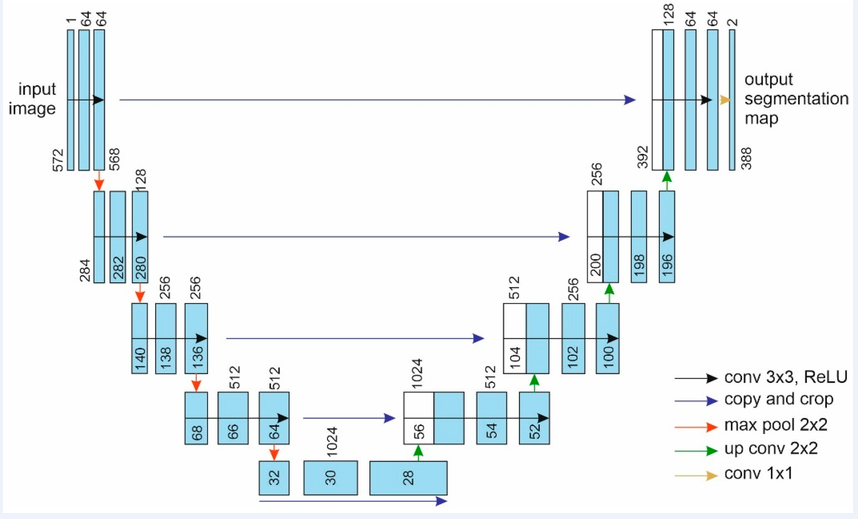

as we can see, the functional keras API is the best option(such the architecture has a concatenate layers) to create $Unet$ model.
as you can relize the blocks of the $Encoder$ and $Decoder$ is the same with some differiations in $filters$ argument , so we can define the $block$ layer as a subclass of $keras.layers.Layer$ and $Unet$ model as subclass of $keras.models.Model$.

In [19]:
class ConvBlock(Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv2D(filters, 3, activation='relu', padding='same')
        self.conv2 = Conv2D(filters, 3, activation='relu', padding='same')
        self.maxpool = MaxPooling2D()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        pool = self.maxpool(x)
        return x, pool


class UNet(Model):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.conv_block1 = ConvBlock(64)
        self.conv_block2 = ConvBlock(128)
        self.conv_block3 = ConvBlock(256)
        self.conv_block4 = ConvBlock(512)
        self.conv_block5 = ConvBlock(1024)
        self.upconv4 = Conv2D(512, 2, activation='relu', padding='same')
        self.upconv3 = Conv2D(256, 2, activation='relu', padding='same')
        self.upconv2 = Conv2D(128, 2, activation='relu', padding='same')
        self.upconv1 = Conv2D(64, 2, activation='relu', padding='same')
        self.up1 = UpSampling2D()
        self.up2 = UpSampling2D()
        self.up3 = UpSampling2D()
        self.concat = Concatenate()
        self.final_conv = Conv2D(num_classes, 1, activation='softmax')

    def call(self, inputs):
        inputs=tf.cast(inputs, tf.float32)
        x, pool1 = self.conv_block1(inputs)
        x, pool2 = self.conv_block2(pool1)
        x, pool3 = self.conv_block3(pool2)
        x, pool4 = self.conv_block4(pool3)

        x = self.conv_block5(pool4)

        x = self.upconv4(x)
        x = self.up1(x)
        x = self.concat([x, pool4])

        x = self.upconv3(x)
        x = self.up2(x)
        x = self.concat([x, pool3])

        x = self.upconv2(x)
        x = self.up3(x)
        x = self.concat([x, pool2])

        x = self.upconv1(x)
        x = self.concat([x, pool1])

        x = self.final_conv(x)

        return x

In [18]:
############-------- Other Definition Of UNet--------#############
# Define the encoder block
class EncoderBlock(Layer):

    def __init__(self,
                 filters:int,
                 kernel_size:tuple[int]):

        # Define the initializer of the parent class
        super(EncoderBlock, self).__init__()

        self.conv = Conv2D(filters, kernel_size, activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs):
        #inputs=tf.expand_dims(inputs, axis=-1)
        x = self.conv(inputs)
        #x= x[0,:,:,:,:]
        print(x.shape)
        x = self.pool()
        return x

# Define the decoder block
class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size):
        super(DecoderBlock, self).__init__()
        self.up = UpSampling2D(size=(2, 2))
        self.conv = Conv2D(filters, kernel_size, activation='relu', padding='same')

    def call(self, inputs, skip):
        x = self.up(inputs)
        x = tf.concat([x, skip], axis=-1)
        x = self.conv(x)
        return x

# Define the UNet model
class UNet2(Model):

    def __init__(self, num_classes=3):
        # Define the initializer of the parent class
        super(UNet2, self).__init__()
        self.encoder1 = EncoderBlock(64, 3)
        self.encoder2 = EncoderBlock(128, 3)
        self.encoder3 = EncoderBlock(256, 3)
        self.encoder4 = EncoderBlock(512, 3)
        self.center = Conv2D(1024, 3, activation='relu', padding='same')
        self.decoder4 = DecoderBlock(512, 3)
        self.decoder3 = DecoderBlock(256, 3)
        self.decoder2 = DecoderBlock(128, 3)
        self.decoder1 = DecoderBlock(64, 3)
        self.output_conv = Conv2D(num_classes, 1, activation='softmax')

    def call(self, inputs):
        #inputs=tf.cast(inputs, tf.float32)
        #inputs=tf.expand_dims(inputs, axis=-1)
        x1 = self.encoder1(tf.expand_dims(tf.cast(inputs, tf.float32), axis=-1))
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        center = self.center(x4)
        x = self.decoder4(center, x4)
        x = self.decoder3(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder1(x, x1)
        output = self.output_conv(x)
        return output

# Create an instance of the UNet model
#model = UNet(num_classes=3)  # Set num_classes to the number of segmentation classes

In [25]:
import numpy as np 
import os
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(input_size =( 1303, 912, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    #padded_up6 = ZeroPadding2D((0, 1))(up6)
    print(drop4.shape,  up6.shape)
   
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    padded_conv3=conv3[:, 1:, :, :]
    print(padded_conv3.shape,  up7.shape)
    merge7 = concatenate([padded_conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    padded_conv2=conv2[:, 3:, :, :]
    print(padded_conv2.shape, up8.shape)
    merge8 = concatenate([padded_conv2,up8], axis = 2)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)


    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(conv8))
    #resh_conv1= Reshape((None, 650, 912, 64))(conv1)
    #reshup9= Reshape((None, 648, 912, 64))(up9)
    #conv1=conv1[:, 3:, :, :]
    padded_up19 = ZeroPadding2D((4, 0))(up9) 
    padded_up29=padded_up19[:, 1:, :, :]
    print(conv1.shape,padded_up29.shape)
    merge9 = concatenate([conv1, padded_up29 ], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs= inputs, outputs = conv10)
    #print(conv10.shape)

    model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    return model

In [26]:
print(X_train[0].shape, y_train[0].shape)

(2279, 1303, 912) (2279, 1303, 912)


In [29]:

#tf.experimental.numpy.experimental_enable_numpy_behavior()     
#X_train[0]=X_train[0].reshape((2279, 1303, 912, 1))
#y_train[0]=y_train[0].reshape((2279, 1303, 912, 1))

# detect and init the tpu
tpu=tf.distribute.cluster_resolver.TPUClusterResolver()

# istantiating a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy=tf.distribute.TPUStrategy(tpu)

# instantating thhe model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():

    ### create an Unet object
    unet=unet()
    #compile the model
    unet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
   #unet.compile(loss=DiceLoss , optimizer='adam', metrics=[DiceLoss])
   #unet.compile(loss=DiceLoss , optimizer='adam', metrics=[DiceLoss])
    unet.summary()
# train the model
#import numpy as np
#X_train[0]=np.expand_dims(X_train[0], axis=-1)
#y_train[0]=np.expand_dims(y_train[0], axis=-1)


#unet.fit(X_train[0], y_train[0], epochs=5) 
#import gc 
#gc.collect()




INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

2024-01-30 05:59:03.252765: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 05:59:03.252867: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


(None, 162, 114, 512) (None, 162, 114, 512)
(None, 324, 228, 256) (None, 324, 228, 256)
(None, 648, 456, 128) (None, 648, 456, 128)
(None, 1303, 912, 64) (None, 1303, 912, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1303, 912, 1)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1303, 912, 64)        640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1303, 912, 64)        36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (M

In [ ]:
unet.fit(X_train[0], y_train[0], epochs=5) 

Epoch 1/5


2024-01-30 06:00:08.957613: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:08.974927: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:08.992586: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:09.010111: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:09.027923: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:09.045354: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-30 06:00:09.063276: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [ ]:
def train_model(model: Model, X_train, y_train, 
                EPOCHS:int,Val_data, BATCH_SIZE=32,
                CALLBACKS=[CALLBACKS], trainable=True)->None:
    
    # model compile assertion
    if model.optimizer is None:
        raise ValueError('you must call model.compile() before using the model')
    
         if not trainable:
             print('the model is not training')
    
         else:
             print('the model is  training')
             model.fit(X_train=X_train, y_train=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                   validation_data=Val_data, callbacks=CALLBACKS)
        
        
        
    

In [ ]:

def make_preditions(model:Model=Unet, image:Tensor)->Tensor:
    '''
    this is a helper function to tranform prediction made by the model 
    into approprite form for visualization
    the process is a little ambigous ..., i don't understand it well,
    but(as you said in english) let's give it a try
    '''
    expected_shape=image.shape
    actual_shape=model.input_shape[1:]  # Exclude the batch dimension

    if not assert_shapes(expected_shape, actual_shape) 
        raise ValueError(f"Model input shape does not match the image shape: {expected_shape} != {actual_shape}")
        
    pred_label=model(image)
    # find the index of the max value in last axis(axis=-1)
    
    pred=argmax( pred_label, axis=-1)
    # add new axe to the  pred_label tensor
    
    pred_label= pred_label[..., newaxis]
    # take the first element of the  pred_label tensor
    
    pred_label=pred_label[0]
    return  pred_label


# helper function to show results
def show_segmentation_results(image, label, predicted_label, before_training=False, colormap='gray'):
             titles=['image', 'label', 'predicted_label']
             # Create a figure with three subplots
             fig, axs = plt.subplots(1, 3, figsize=(12, 4))

             # Display the original image
             axs[0].imshow(image)
             axs[0].set_title(titles[0])

             # Display the ground truth label
             axs[1].imshow(label, cmap='gray')
             axs[1].set_title(titles[1])

             # Display the predicted label
             axs[2].imshow(predicted_label, cmap='gray')
             axs[2].set_title(titles[2])

             # Remove the axis labels
             for ax in axs:
                ax.axis('off')

             # Adjust the spacing between subplots
             plt.tight_layout()

             # Show the plot
             plt.show()

    
def display_predictions(model=Unet:Model, num_samples:int=1, index:int=550, before_trainig:bool=True)->None:
    
      # we diplay one prediction of the unet for each dataset
      for i in trange(4):
            assert index in range(len(X_train[i]))
            image=X_train[i][index]
            label=y_train[i][index]
        
            if before_training:
                    # we make sure that the model is not trainable
                    if model.trainable:
                         raise ModelIsTrainableError('the model is trainable')
                    
                    else:
                          # we make predictions
                          pred_label=make_preditions(model, image)
                          print('the results before training')
                          show_segmentation_results(image, label, predicted_label, before_training=before_training)
                          print(f'set the bool argument before_trainig to True to show the predictions made by the {Unet} after feeding the model by the data')
        
            else:
        
                    # we make sure that the model is trainable
                    if not model.trainable:
                         raise ModelNotTrainableError('the model is not trainable set model.trainable to True')
         
                    # otherwise we make predictions
                    else:
                         pred_label=make_preditions(model=model, image=imge)
                         print('the results after training the model')
                         show_segmentation_results(image, label, before_training=before_training)
                         print(f'set the bool argument before_trainig to False to show the predictions made by the {Unet} beforer feeding the model by the data')
                  

## Cross Validation:

if you want to know about kfold (from scratch), check out this https://github.com/said-ml/pattern-recognition-and-machine-learning/blob/main/Chapter1%3AIntroduction/cross-validation.ipynb

In [ ]:
# if you want to know about kfold (from scratch )
kfold=KFold(n_splits=5, shuffle=True, random_stae=42)

# we want to store accuracies and losses of the model
losses=[]
accuracies=[]

for (train, test), fold  in enumerate(zip(kfold(X, y))):
    # we train the model
    model.fit(X[train], y[train], epochs=25, batch_size=32)
    # model's evaluation and testing
    loss, accuracy=model.evaluate(X[test], y[test])
    losses.append(loss)
    accuracies.append(accuracy)
    print(f"Fold: {fold + 1}, Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Loss: {np.mean(losses):.4f}")

# some plots to track losses and accuracies in each fold

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(kfold.split(X, y)) + 1), accuracies, label='Accuracy')
plt.plot(range(1, len(kfold.split(X, y)) + 1), losses, label='Loss')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.title('KFold Cross-Validation Results')
plt.legend()
plt.show()


## Fine-Tune with kerastuner:

we can use sklearn.model_selection to select our algorithm of optimization(e, g $GridSearchCV$, $BayesianSearch$...) to finfd good hypeparameters ($optimizer$, learning_rate, $activations$, $droput$, $regularizations$, weights_initialization , $layers$(eg,$CNNs$, $RNNs$, $DNNs$...etc) to build a robust model for our task.

but instaed we use $kerastuner$ to performe this .

but before that we must define a function that all possible of sets of combinaisons of the hyparameters that we can choose from, and use $kerastuner$ the choose the best combinaison

In [ ]:
def build_model()

In [ ]:
# We create a RandomSerach object as the first tuner
tuner=Randomsearch(hypermodel:Callable=build_model(), 
                   # this function provided a set of values of each parameters that we can choose from it
                   objective:Callable=accuracy        
                   # this is metric of the model tha we want to potimze it
                   max_trials:int=10,                 
                   # number of configurations 
                   directory=None,
                   # directory is optinal to save the model
                   projection_name:str='Human Vasculature in 3D with keras/tensorflow'
                  )

# Search the best hyperparameters
tuner.search(X_train, y_train,
             validation_data=(x_val, y_val),
             epochs=5,
             callbacks=EarlyStopping(patience=3)
            )

# Get The Best Hyperparameters:
best_hypers=tuner.get_best_hyperparameters(num_trials=1)[0]
best_models=tuner.hypermodel.build(best_hyperparameters)


                   
                   

## 

## Results Analysis:

In [ ]:
from numbers import Integral, Real
a=1
if isinstance(a, Real):
    print('the code is work', type(Integral), type(a))

In [ ]:
import random
def upvote(you_like_it:bool=True)->str:
    
    if you_like_it:
         return random.choice(['upvote it', 'leave a comment'])

    else:
         return 'self descipline is the key of success'
upvote()

## Pretrained_Model:

In [5]:
import keras_cv
from keras_cv.models import DeepLabV3Plus
print(keras_cv.__version__)

# Define The head Of the model
segmentation_head=Sequential([Conv2D(filters=32,
                                     kernel_size=1, 
                                     padding='same',
                                     use_bias=False,
                                    ),
                             BatchNormalization(),
                             ReLU(),
                             UpSampling2D(size=(4, 4),
                                        interpolation='bilinear'),
                             Conv2D(filters=3,
                                     kernel_size=1, 
                                     padding='same',
                                     use_bias=False,
                                     activation='sigmoid',
                                     dtype='float32')
                                    ], name='segmentation_head')

# Define the backbone model
# load the DeepLabV3+ model

backbone=DeepLabV3Plus.from_prset(   ,
                                  input_shape=[size, 3],
                                   )

## Take Only The Backbone Before Head
neck_layer_name=backbone.layers[-2].name
out=backbone.get_layer(neck_layer_name).output

# use defined head for segmentation
segmentation_head(out)

# create a new model
model=Model(learning_rate=1e-4)




# D

0.8.0.dev0


In [4]:
import keras_cv
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2
keras_cv.__version__


Using TensorFlow backend


'0.8.0.dev0'